In [ ]:
"""
This notebook takes the cropped slides and finds the wings in them, labels them left and right based on their position and segments them. 
"""

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from copy import deepcopy

from scipy import ndimage
from pathlib import Path
from skimage.measure import label

from numpy import linalg
from scipy.sparse.linalg import eigs

In [6]:
sorted([Path(x).name for x in glob('../1_slides/2_blob_problems/*')])

['Hive01_Sheet_03_slideww49.png',
 'Hive02_Sheet_01_slide33.png',
 'Hive02_Sheet_02_slide64.png',
 'Hive02_Sheet_03_slideww19.png',
 'Hive02_Sheet_03_slideww35.png',
 'Hive03_Sheet_01_slide115.png',
 'Hive03_Sheet_01_slide31.png',
 'Hive03_Sheet_01_slideww33.png',
 'Hive07_Sheet_03_slide101.png',
 'Hive07_Sheet_03_slide112.png',
 'Hive08_Sheet_03_slide7.png',
 'Hive08_Sheet_06_slide75.png',
 'Hive10_Sheet_03_slide87.png',
 'Hive12_Sheet_01_slide23.png',
 'Hive13_Sheet_02_slideww32.png',
 'Hive14_Sheet_01_slideww18.png',
 'Hive16_Sheet_02_slide38.png',
 'Hive18_Sheet_01_slide10.png',
 'Hive21_Sheet_01_slide20.png',
 'Hive25_Sheet_01_slide70.png',
 'Hive25_Sheet_01_slideww15.png',
 'Hive28_Sheet_01_slide17.png',
 'Hive28_Sheet_02_slide33.png',
 'Hive28_Sheet_03_slide65.png',
 'Hive28_Sheet_03_slide84.png',
 'Hive28_Sheet_03_slide93.png',
 'Hive33_Sheet_01_slideww42.png',
 'Hive34_Sheet_01_slideww26.png',
 'Hive38_Sheet_02_slide44.png',
 'Hive39_Sheet_02_slide51.png',
 'Hive39_Sheet_03_sl

In [124]:
# Some slides only have one wing which makes it hard to automatically find two big blobs
# So these are hardcoded also for which 'side' they are.

single_wings = {
    'Hive01_Sheet_03_slideww49':'right',
 'Hive02_Sheet_01_slide33':'right',
 'Hive02_Sheet_02_slide64':'left',
 'Hive02_Sheet_03_slideww19':'right',
 'Hive02_Sheet_03_slideww35':'right',
 'Hive03_Sheet_01_slide31':'left',
 'Hive03_Sheet_01_slideww33':'right',
 'Hive07_Sheet_03_slide101':'left',
 'Hive07_Sheet_03_slide112':'right',
 'Hive08_Sheet_03_slide7':'right',
 'Hive08_Sheet_06_slide75':'left',
 'Hive10_Sheet_03_slide87':'left',
 'Hive12_Sheet_01_slide23':'left',
 #'Hive13_Sheet_02_slideww32.png':'', two wings, one deformed and small
 'Hive14_Sheet_01_slideww18':'left',
 'Hive16_Sheet_02_slide38':'left',
 'Hive18_Sheet_01_slide10':'left',
 'Hive21_Sheet_01_slide20':'left',
 #'Hive25_Sheet_01_slide70.png', two very small wings
 #'Hive25_Sheet_01_slideww15.png',, two very small wings
 #'Hive28_Sheet_01_slide17.png',, two big wings
 'Hive28_Sheet_02_slide33':'left',
 #'Hive28_Sheet_03_slide65.png',, two wings, one deformed and small
 'Hive28_Sheet_03_slide84':'right',
 'Hive28_Sheet_03_slide93':'left',
 'Hive33_Sheet_01_slideww42':'right',
 'Hive34_Sheet_01_slideww26':'left',
 'Hive38_Sheet_02_slide44':'right',
 #'Hive39_Sheet_02_slide51.png',,, two very small wings
 'Hive39_Sheet_03_slide104':'right', # writing on slide.
 'Hive40_Sheet_03_slide87':'right',
    'Hive05_Sheet_01_slide118':'right'
}


In [125]:
def segment_contour(img, contour):
    """
    Given an image and a contour from that image, 
    return a segmentation of the pixels inside the contour
        and the mask of the contour pixels
    """
    box_min_x, box_min_y = contour.min(axis=0)[0]
    box_max_x, box_max_y = contour.max(axis=0)[0]

    x,y,w,h = cv2.boundingRect(contour)
    
    seg = np.ones(img.shape)*255
    mask = np.zeros(img.shape)
    mask = cv2.drawContours(mask, [contour], -1, (1,1,1), -1)
    seg[np.where(mask > 0)] = img[np.where(mask>0)]
    
    return seg.astype('uint8'), mask

In [126]:
def crop_to_contour(img, contour):
    """
    Given an image and a contour from that image, 
    return a crop of the pixels inside the contour
        and the mask of the contour pixels
    """
    box_min_x, box_min_y = contour.min(axis=0)[0]
    box_max_x, box_max_y = contour.max(axis=0)[0]

    x,y,w,h = cv2.boundingRect(contour)
    
    crop = img[y:y+h, x:x+w]
    mask = np.zeros(img.shape)
    mask = cv2.drawContours(mask, [contour], -1, (1,1,1), -1)
    mask = mask[y:y+h, x:x+w]
    
    return crop, mask


In [127]:
# Plot line of rotation

def rotate_wing(wing, wing_mask, wing_contour, left_wing=False):
    # crop image to contour
    x,y,w,h = cv2.boundingRect(wing_contour)
    c = wing_contour.squeeze() - np.array([x,y])
    cropped_wing = deepcopy(wing[y:y+h, x:x+w])
    cropped_wing_mask = deepcopy(wing_mask[y:y+h, x:x+w])
    
    
    M  = np.cov(c.T)
    vals, vects = eigs(M)
    biggest_eigval = np.argmax(vals)
    rotation_vect = vects[biggest_eigval]
    angle = np.arctan(rotation_vect[1]/rotation_vect[0])
    centroid = c.mean(axis=0).astype('int')

    #rotation angle in degree
    wing_rotated = ndimage.rotate(cropped_wing, -angle*180/np.pi, mode='constant', cval=255)

    
    wing_mask_rotated = ndimage.rotate(cropped_wing_mask, -angle*180/np.pi, mode='constant', cval=0)
    wing_mask_rotated = (wing_mask_rotated[:,:,0] > 0.5).astype('int')
    
    if left_wing:
        wing_rotated = np.fliplr(wing_rotated)
        wing_mask_rotated = np.fliplr(wing_mask_rotated)
    #plt.imshow(wing_rotated)
    #plt.title('Left')
    #plt.imshow(wing_mask_rotated)
    #plt.title('Left')
    
    rotated_contours,hierarchy = cv2.findContours(wing_mask_rotated.astype('uint8'), 1, 2)
    biggest_contour_idx = np.argsort([cv2.contourArea(x) for x in rotated_contours])[-1]
    biggest_contour = rotated_contours[biggest_contour_idx]
    x,y,w,h = cv2.boundingRect(biggest_contour)

    # detect flipped wings
    # centroid = rotated_contour.mean()
    
    if DEBUG:
        plt.figure()
        plt.imshow(wing_rotated)
        plt.figure()
        plt.imshow(wing_rotated[y:y+h,x:x+w])
        if left_wing:
            plt.title('Left')
        else:
            plt.title('Right')
    return wing_rotated[y:y+h, x:x+w], wing_mask_rotated[y:y+h, x:x+w]

In [165]:
def segment_biggest_contour_below_threshold(image, threshold=170, slide_name=None):
    #blurred = cv2.blur(image, (1, 1))
    thres = (image[:,:,0] < threshold).astype('uint8')*255

    
    if slide_name == 'Hive01_Sheet_03_slideww21-x':
        thres = (image[:,:,2] < 180).astype('uint8')*255
        
    if DEBUG:
        plt.figure()
        plt.imshow(thres)
    contours,hierarchy = cv2.findContours(thres.astype('uint8'), 1, 2)
    biggest_contour_idx = np.argsort([cv2.contourArea(x) for x in contours])[-1]
    biggest_contour = contours[biggest_contour_idx]
    
    mask = np.zeros(image.shape)
    mask = cv2.drawContours(mask, [biggest_contour], -1, (1,1,1), -1)
    if DEBUG:
        plt.figure()
        plt.imshow(mask)
    seg = np.ones(image.shape)*255
    seg[np.where(mask > 0)] = image[np.where(mask>0)]
    if DEBUG:
        plt.figure()
        plt.imshow(seg)
    return seg.astype('uint8'), mask, biggest_contour

def rotate_segment_crop_save_wing(slide_name, slide, contour, side):
    crop, mask = crop_to_contour(slide, contour)
    wing, mask, contour = segment_biggest_contour_below_threshold(crop, threshold=170, slide_name=slide_name)
    if slide_name == 'Hive16_Sheet_02_slide38':
        wing, mask, contour = segment_biggest_contour_below_threshold(crop, threshold=200)
    wing, mask = rotate_wing(wing, mask, contour, left_wing=True if side == 'left' else False)

    # Janky way to flip back ones that were improperly flipped
    thres = wing[:,:,1] < 5
    
    if DEBUG:
        plt.figure()
        plt.imshow(thres)
    if side == 'left':
        if np.where(thres)[0].mean() > 0.5*thres.shape[0]:
            # flip back
            wing = np.flipud(wing)
            mask = np.flipud(mask)
        if np.where(thres)[1].mean() > 0.5*thres.shape[1]:
            # flip back
            wing = np.fliplr(wing)
            mask = np.fliplr(mask)

    elif side == 'right':
        if np.where(thres)[0].mean() > 0.5*thres.shape[0]:
            # flip back
            wing = np.flipud(wing)
            mask = np.flipud(mask)
        if np.where(thres)[1].mean() > 0.5*thres.shape[1]:
            # flip back
            wing = np.fliplr(wing)
            mask = np.fliplr(mask)

    if slide_name == 'Hive28_Sheet_03_slide93':
        wing = np.fliplr(wing)
        mask = np.fliplr(mask)

    

    fn = slide_name + f'_{side}.png'
    if fn in ['Hive02_Sheet_03_slideww47_right.png', 'Hive02_Sheet_03_slideww70_left.png', 'Hive18_Sheet_03_slide104_left.png',
             'Hive22_Sheet_01_slide45_right.png','Hive24_Sheet_01_slideww18_left.png','Hive25_Sheet_01_slide30_left.png',
             'Hive31_Sheet_01_slide51_right.png','Hive32_Sheet_01_slide20_left.png','Hive32_Sheet_01_slide22_left.png',
             'Hive32_Sheet_01_slide44_right.png','Hive32_Sheet_01_slide57_right.png','Hive32_Sheet_01_slideww11_right.png',
             'Hive32_Sheet_01_slideww18_left.png','Hive33_Sheet_01_slideww49_left.png','Hive33_Sheet_01_slideww49_right.png',
             'Hive34_Sheet_01_slide27_right.png','Hive34_Sheet_01_slideww53_left.png','Hive34_Sheet_01_slideww53_right.png',
             'Hive40_Sheet_04_slide132_left.png','HiveC2_Sheet_02_slide25_left.png']:
        wing = np.fliplr(wing)
        mask = np.fliplr(mask)
        
    if DEBUG:
        plt.figure()
        plt.imshow(wing)
        plt.title(side + '_last')
    
    fp = '../1_slides/2_individual_wings/' + fn
    mask_fp = '../slides/2_masks/' + slide_name + f'_{side}.png'
    cv2.imwrite(fp, wing)
    cv2.imwrite(mask_fp, mask*255)

  0%|                                                                                                                                                                               | 0/2286 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
/tmp/ipykernel_53918/673650139.py:12: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  vals, vects = eigs(M)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
  0%|                                                                                                                                                                               | 0/2286 [00:00<?, ?it/s]


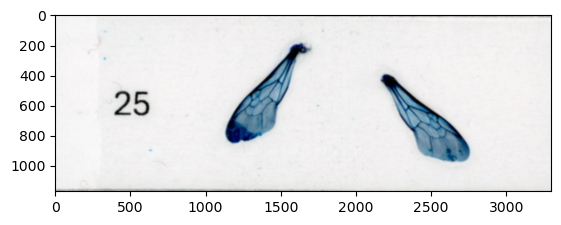

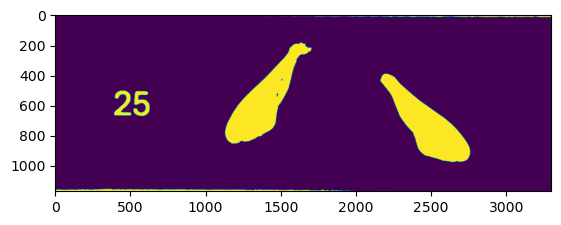

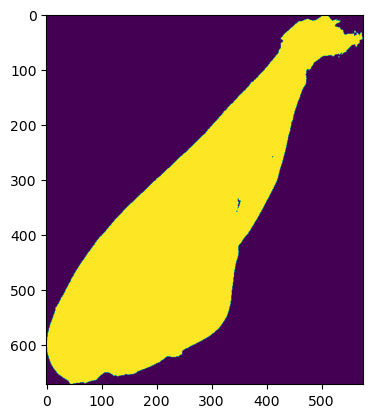

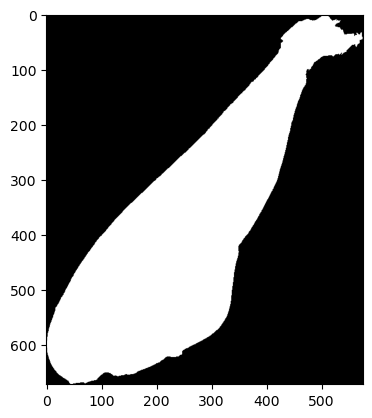

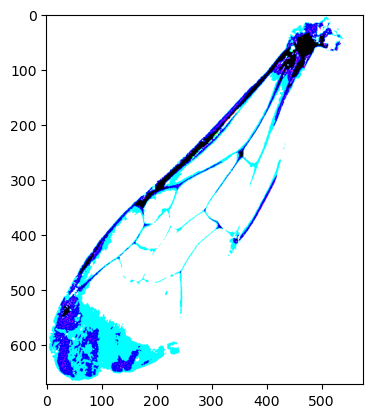

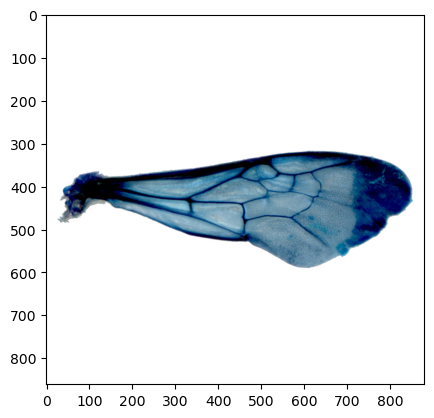

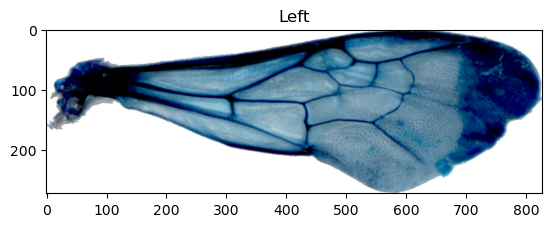

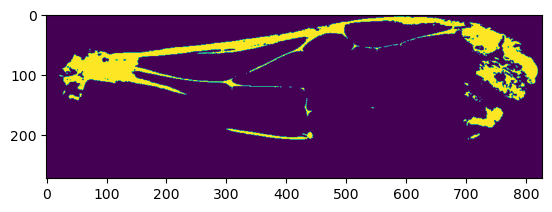

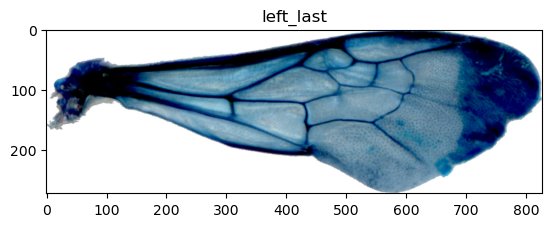

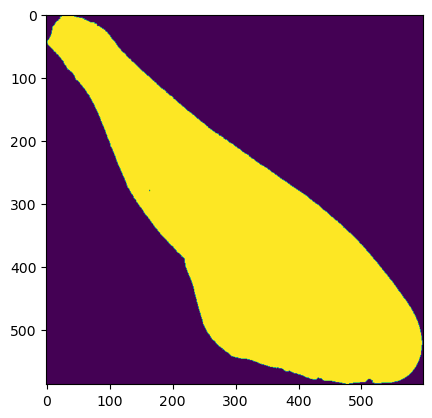

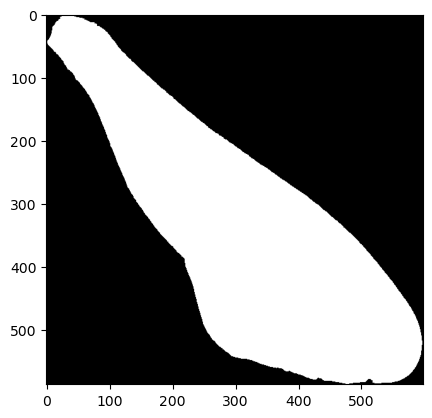

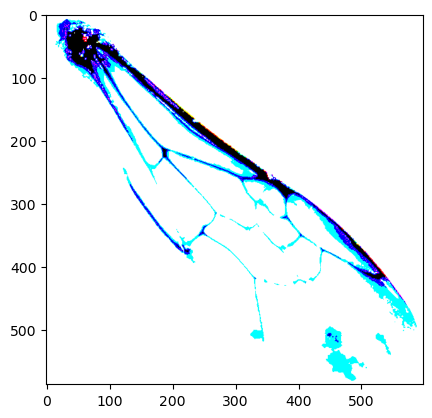

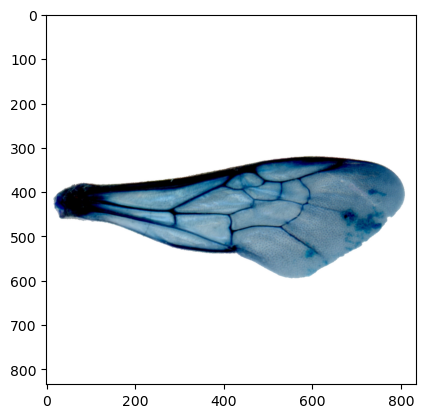

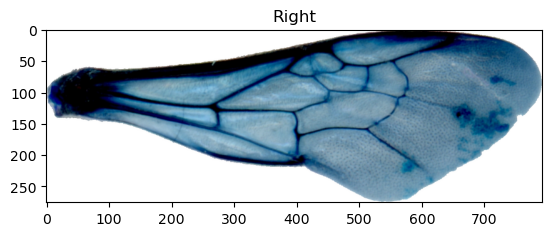

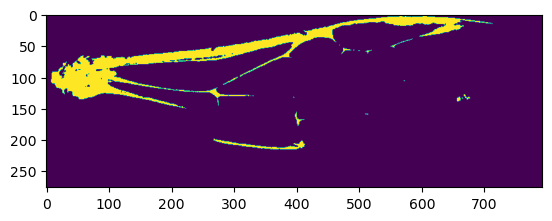

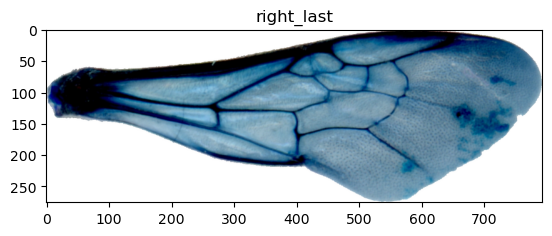

In [166]:
DEBUG = True
N_SLIDES = 1000000

slide_fps = glob('../1_slides/1_slides/*')
np.random.seed(42)
np.random.shuffle(slide_fps)

for slide_fp in tqdm(slide_fps[:N_SLIDES]):
    
    if DEBUG:
        slide_fp = '../1_slides/1_slides/HiveC2_Sheet_02_slide25.png'
    
    slide_name = slide_fp.split('/')[-1].split('.')[0]

    slide = cv2.imread(slide_fp)
    blurred = cv2.blur(slide, (11, 11))

    thres = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY) < 190
    if slide_name == 'Hive05_Sheet_01_slideww92':
        thres = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY) < 175

    if slide_name == 'Hive16_Sheet_02_slide38':
        thres = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY) < 200
    if slide_name == 'Hive28_Sheet_01_slide17':
        thres = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY) < 120
    if slide_name == 'Hive01_Sheet_03_slideww21-x':
        thres = blurred[:,:,2] < 190
    if DEBUG:
        plt.figure()
        plt.imshow(blurred)
        plt.figure()
        plt.imshow(thres)

    contours,hierarchy = cv2.findContours(thres.astype('uint8'), 1, 2)
    two_biggest_blobs = []
    i=1
    # encountered an error that it would detect dark edges sometimes instead, so just find a blob
    # with a reasonable aspect ratio
    area_sorted_indices = np.argsort([cv2.contourArea(x) for x in contours])
    while (len(two_biggest_blobs) < 2) and (i<10):
        if i >= len(area_sorted_indices):
            break
        blob_index = area_sorted_indices[-i]
        i+=1
        x,y,w,h = cv2.boundingRect(contours[blob_index])
        blob_area = cv2.contourArea(contours[blob_index])

        if w/h > 5 or h/w > 5:
            #plt.figure()
            #plt.title('Aspect ratio too high')
            #plt.imshow(thres)
            #aspect ratio too high, found edge
            pass
        elif (blob_area < 55000) and (slide_name not in ['Hive25_Sheet_01_slideww15','Hive25_Sheet_01_slide70']):
            #plt.figure()
            #plt.title('Blob Area too small')
            #plt.imshow(thres)
            # blob is probably too small to be a wing, might be an edge or a word
            pass
        else:
            two_biggest_blobs += [blob_index]

    
    if slide_name == 'Hive01_Sheet_02_slide121-x':
        two_biggest_blobs = [37, 41]
    if (len(two_biggest_blobs) < 2) and (slide_name not in single_wings.keys()):
        if slide_name == 'Hive03_Sheet_01_slide115':
            two_biggest_blobs = [19, 20]
        elif slide_name == 'Hive13_Sheet_02_slideww32':
            two_biggest_blobs = [30, 29]
        elif slide_name == 'Hive28_Sheet_03_slide65':
            two_biggest_blobs = [7, 6]
        elif slide_name == 'Hive39_Sheet_02_slide51':
            two_biggest_blobs = [67, 66]
        else:
            fp = '../1_slides/2_blob_problems/' + slide_name + '.png'
            cv2.imwrite(fp, slide)
            if DEBUG:
                pass
            else:
                continue
    
    if slide_name in single_wings.keys():
        side = single_wings[slide_name]
        wing_contour = contours[two_biggest_blobs[0]]
        rotate_segment_crop_save_wing(slide_name, slide, wing_contour, side)

    else:
        # Identify if both blobs are big enough to be wings
        blob1 = contours[two_biggest_blobs[0]]
        blob2 = contours[two_biggest_blobs[1]]
    
        blob1_mean_x = blob1.mean(axis=0)[0][0]
        blob2_mean_x = blob2.mean(axis=0)[0][0]
        
        if blob1_mean_x < blob2_mean_x:
            left_contour = blob1
            right_contour = blob2
        else:
            left_contour = blob2
            right_contour = blob1

        rotate_segment_crop_save_wing(slide_name, slide, left_contour, 'left')
        rotate_segment_crop_save_wing(slide_name, slide, right_contour, 'right')

    
    if DEBUG:
        break

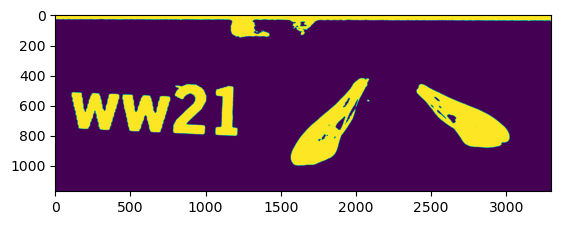

In [100]:
plt.imshow(blurred[:,:,2] < 190)

In [88]:
slide_name

'Hive01_Sheet_02_slide121-x'